``plot_trace``関数でワーニングを出さないため次のコマンド実行が必要です。

In [1]:
#!pip install --upgrade numba | tail -n 1

## 5.2 線形回帰のベイス推論

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/5_2_%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0%E3%81%AE%E3%83%99%E3%82%A4%E3%82%BA%E6%8E%A8%E8%AB%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


###  5.2.1 問題設定
アイリスデータセットで花の種類を特定した場合、２つの項目値には正の相関があり。線形回帰(単回帰)に従うと見なせる。  
当実習では、上の点を前提とした上で、最適な回帰式をベイズ推論で求める。  


### 5.2.2 データ準備

#### データ読み込みと確認

In [5]:
# アイリスデータセットの読み込み
df = sns.load_dataset('iris')

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df['species'].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

#### 分析対象データ抽出

In [6]:
# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# sepal_lengthとsepal_widthの列を抽出
X = df1['sepal_length']
Y = df1['sepal_width']

####  分析対象項目間の散布図表示

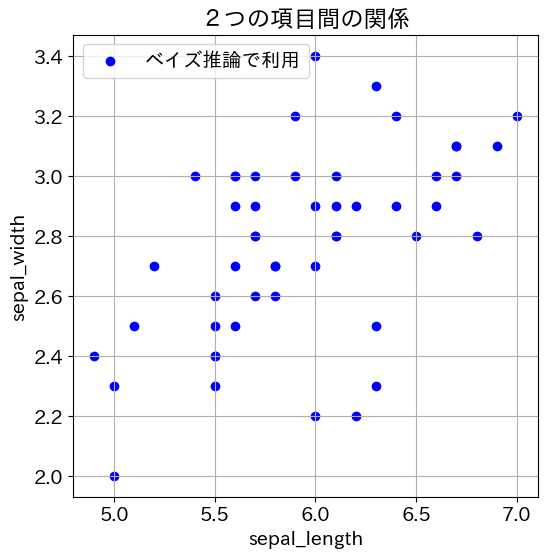

In [7]:
plt.title('２つの項目間の関係')
plt.scatter(X, Y, label='ベイズ推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

### 5.2.3 確率モデル定義1

$ y_n =  \alpha  x_n + \beta +  \epsilon_n$

#### 確率モデル定義1
シンプルなモデル定義の方法

In [8]:
model1 = pm.Model()

with model1:
    # 確率変数alpha、betaの定義(一次関数の傾きと切片)
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta = pm.Normal('beta', mu=0.0, sigma=10.0)

    # 平均値muの計算
    mu = alpha * X + beta

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # 観測値を持つ確率変数はY_obsとして定義
    Y_obs= pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=Y)

#### 確率モデル構造の可視化

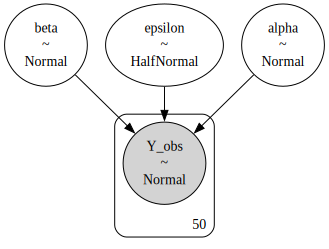

In [9]:
g = pm.model_to_graphviz(model1)
display(g)

### 5.2.4 確率モデル定義2
より詳細なモデル定義の方法

#### 確率モデル定義2

In [10]:
model2 = pm.Model()

with model2:
    # X, Yの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', X)
    Y_data = pm.ConstantData('Y_data', Y)

    # 確率変数alpha、betaの定義(一次関数の傾きと切片)
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta = pm.Normal('beta', mu=0.0, sigma=10.0)

    # 平均値muの計算
    mu = pm.Deterministic('mu', alpha * X_data + beta)

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # 観測値を持つ確率変数はobsとして定義
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=Y_data)

#### 確率モデル構造の可視化

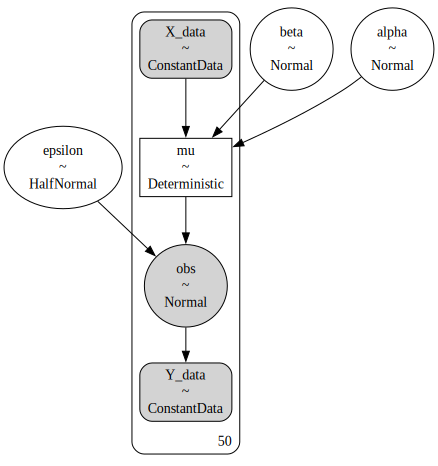

In [11]:
g = pm.model_to_graphviz(model2)
display(g)

### 5.2.5 サンプリングと結果分析

#### サンプリング

In [12]:
with model2:
    idata2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


#### plot_trace関数呼び出し

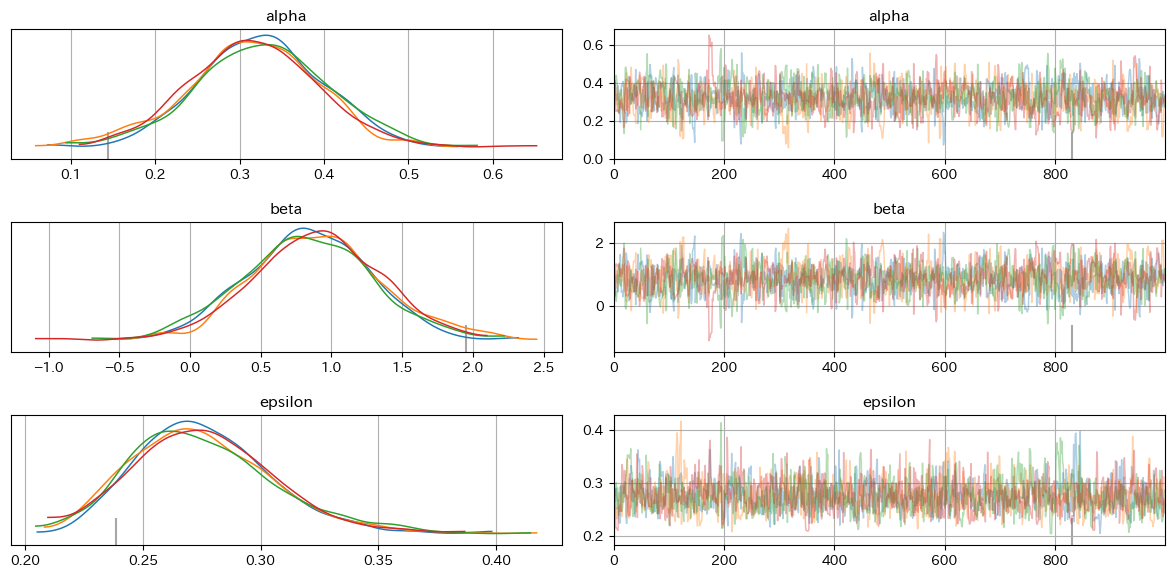

In [13]:
az.plot_trace(idata2, compact=False, var_names=['alpha', 'beta', 'epsilon'])
plt.tight_layout();

#### plot_posterior関数呼び出し

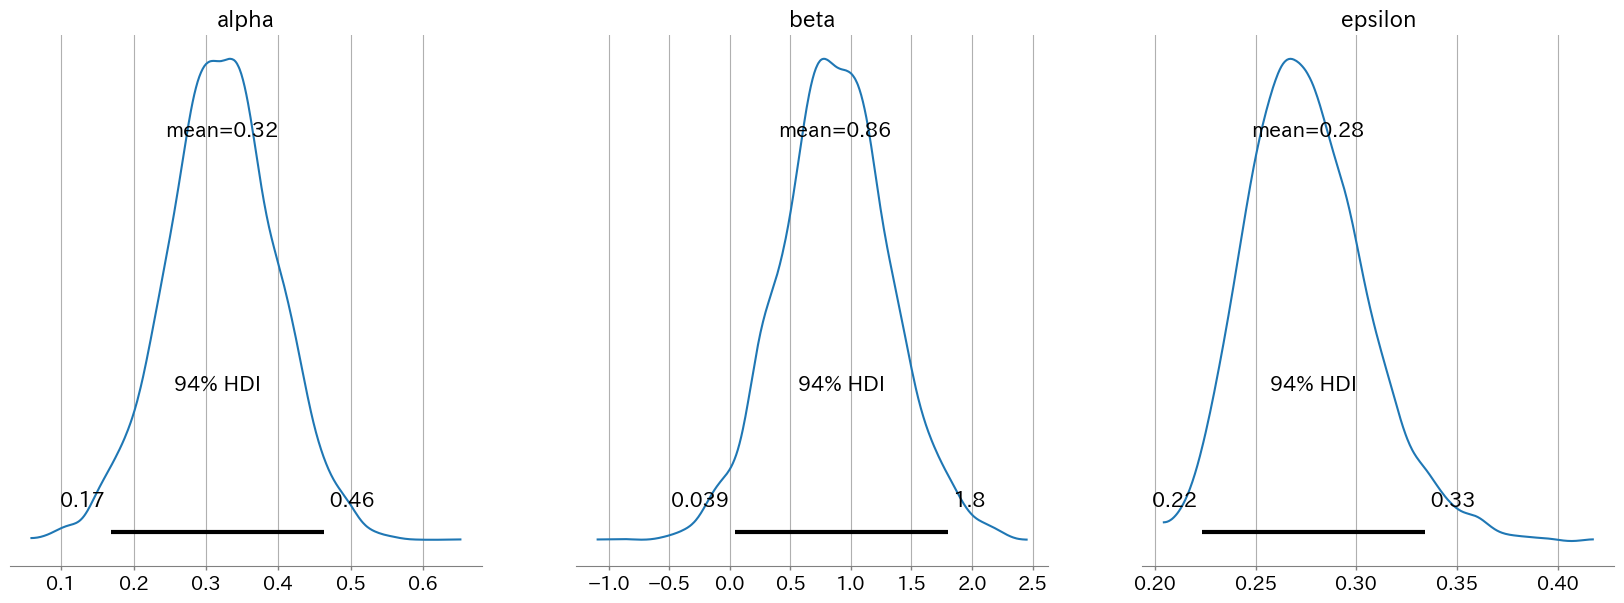

In [14]:
az.plot_posterior(idata2, var_names=['alpha', 'beta', 'epsilon']);

### 5.2.6 散布図と回帰直線の重ね描き

#### 個別のサンプルにおける回帰直線予測値の計算

In [15]:
# xの２点をNumPy配列にする
x_values = np.array([X.min()-0.1, X.max()+0.1])
print(x_values, x_values.shape)

# サンプリング結果からalphaとbetaを取り出しshapeを加工する
alphas2 = idata2['posterior']['alpha'].values.reshape(-1, 1)
betas2 = idata2['posterior']['beta'].values.reshape(-1, 1)

# shapeの確認
print(alphas2.shape, betas2.shape)

# 2000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas2 + betas2
print(y_preds.shape)

[4.800 7.100] (2,)
(4000, 1) (4000, 1)
(4000, 2)


#### ベイズ推論における回帰直線

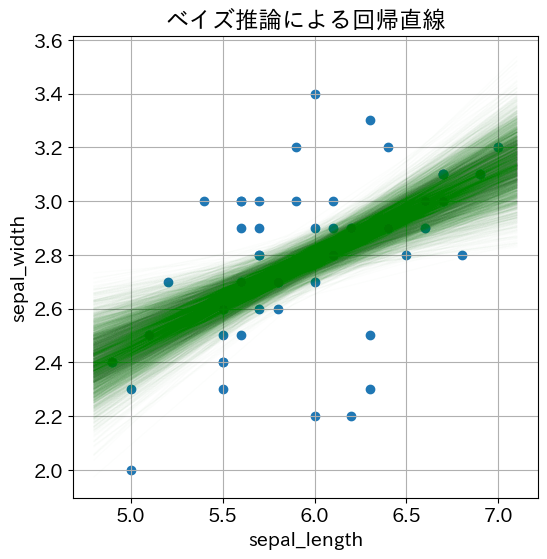

In [16]:
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c='g')
plt.scatter(X, Y)
plt.title('ベイズ推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

###  5.2.7 少ないサンプル数でベイス推論

#### 乱数により3個のインデックスを生成

In [17]:
import random
random.seed(42)
indexes =range(len(X))
sample_indexes=random.sample(indexes, 3)
print('インデックス値', sample_indexes)

# データ数を3個にする
X_less = X.iloc[sample_indexes]
Y_less = Y.iloc[sample_indexes]
print('xの値', X_less.values)
print('yの値', Y_less.values)

インデックス値 [40, 7, 1]
xの値 [5.500 4.900 6.400]
yの値 [2.600 2.400 3.200]


#### 抽出した3点の散布図表示

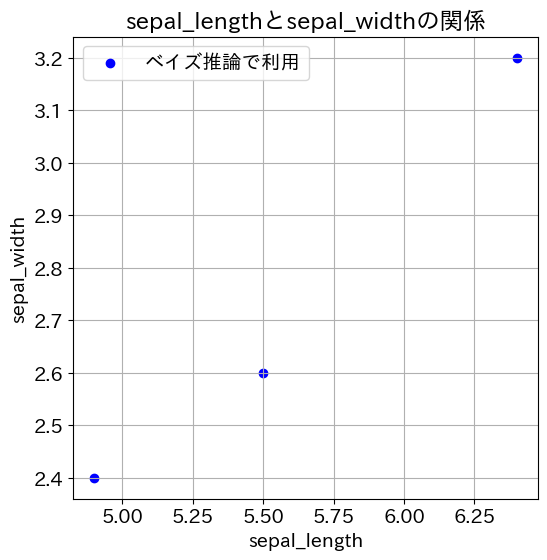

In [18]:
plt.title('sepal_lengthとsepal_widthの関係')
plt.scatter(X_less, Y_less, label='ベイズ推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

#### 確率モデル定義とサンプリング

In [19]:
model3 = pm.Model()

with model3:
    # X, Yの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', X_less)
    Y_data = pm.ConstantData('Y_data', Y_less)

    # 確率変数alpha、betaの定義(一次関数の傾きと切片)
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta = pm.Normal('beta', mu=0.0, sigma=10.0)

    # 平均値muの計算
    mu = pm.Deterministic('mu', alpha * X_data + beta)

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # 観測値を持つ確率変数はobsとして定義
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=Y_data)

    # サンプリング
    idata3 = pm.sample(random_seed=42, target_accept=0.995)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### plot_trace関数でベイズ推論結果の確認

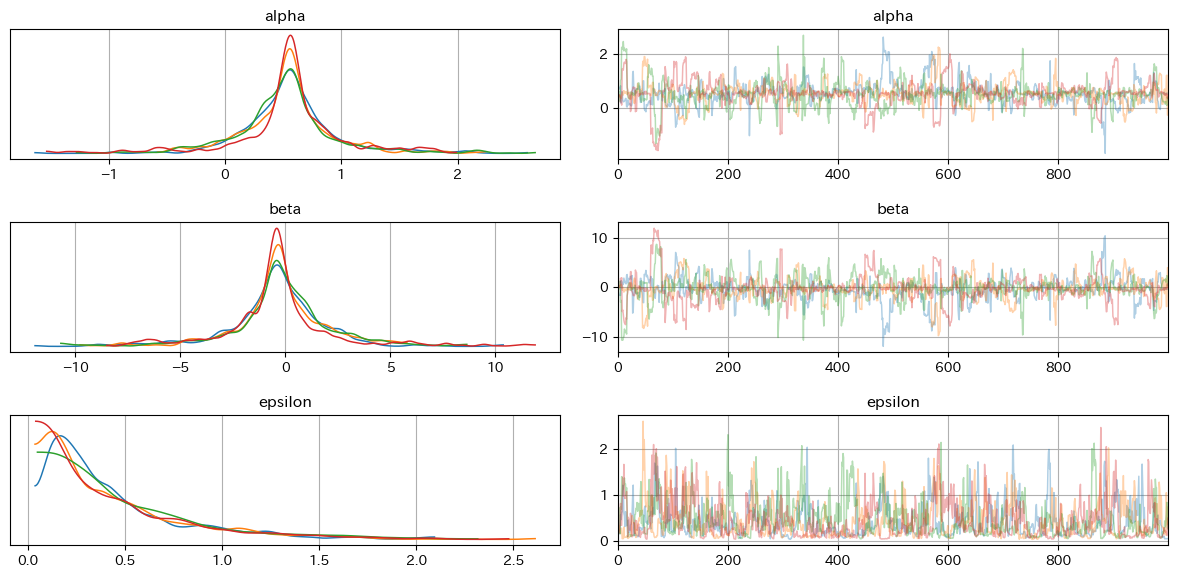

In [20]:
az.plot_trace(idata3, compact=False, var_names=['alpha', 'beta', 'epsilon'])
plt.tight_layout();

#### 散布図と回帰直線の重ね描き

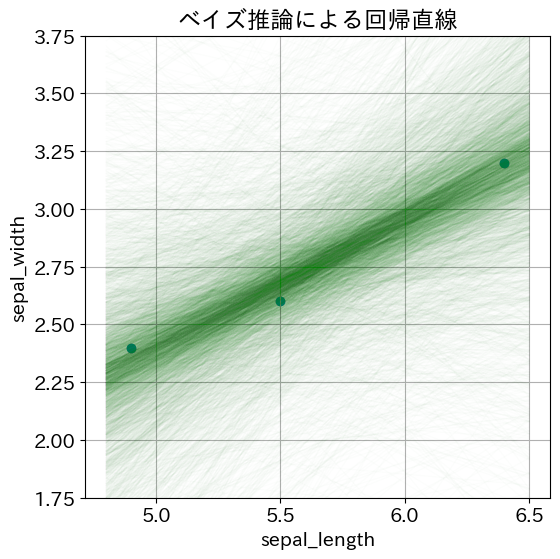

In [21]:
# xの２点をNumPy配列にする
x_values = np.array([X_less.min()-0.1, X_less.max()+0.1])

# サンプル値からalphaとbetaを取り出しshapeを加工する
alphas3 = idata3['posterior']['alpha'].values.reshape(-1, 1)
betas3 = idata3['posterior']['beta'].values.reshape(-1, 1)

# 2000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas3 + betas3

# 2000組の直線を散布図と同時表示
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c='g')
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title('ベイズ推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

### コラム　target_acceptによるチューニング

#### 確率モデル定義とサンプリング(``target_accept``パラメータなし)

In [22]:
model4 = pm.Model()

with model4:
    # X, Yの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', X_less)
    Y_data = pm.ConstantData('Y_data', Y_less)

    # 確率変数alpha、betaの定義(一次関数の傾きと切片)
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta = pm.Normal('beta', mu=0.0, sigma=10.0)

    # 平均値muの計算
    mu = pm.Deterministic('mu', alpha * X_data + beta)

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # 観測値を持つ確率変数はobsとして定義
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=Y_data)

    # サンプリング
    idata4 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 473 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### plot_trace関数でベイズ推論結果の確認

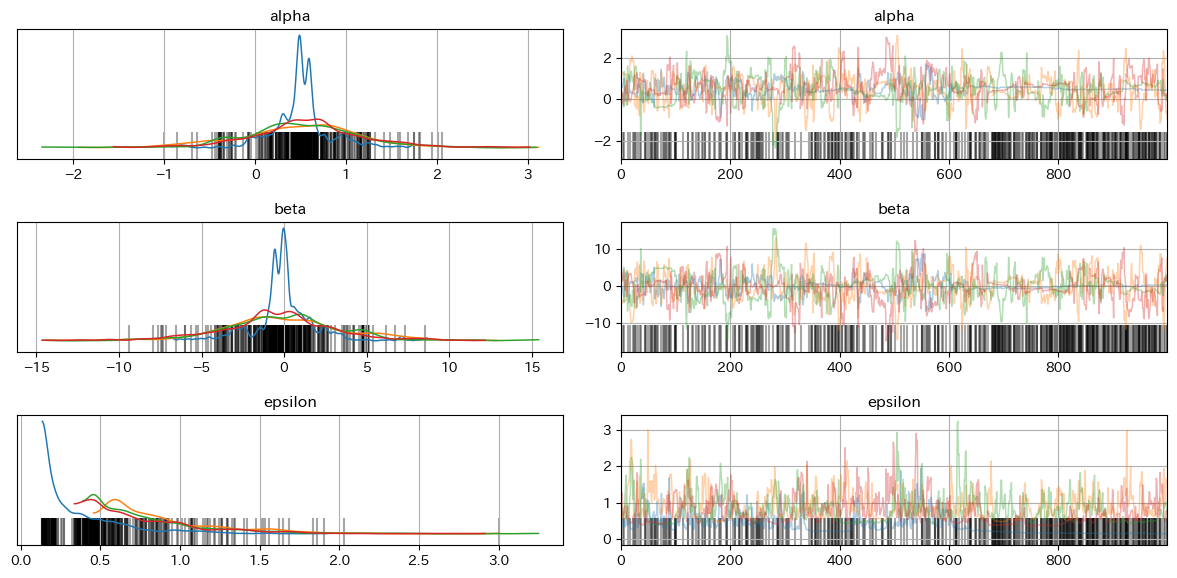

In [23]:
az.plot_trace(idata4, compact=False, var_names=['alpha', 'beta', 'epsilon'])
plt.tight_layout();

#### summary関数でベイズ推論結果の確認

In [24]:
summary4 = az.summary(idata4, var_names=['alpha', 'beta', 'epsilon'])
display(summary4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.513,0.607,-0.698,1.728,0.026,0.023,512.000,615.000,1.110
beta,-0.137,3.397,-7.259,6.230,0.149,0.161,504.000,627.000,1.110
epsilon,0.697,0.408,0.134,1.433,0.100,0.072,10.000,11.000,1.300


#### 散布図と回帰直線の重ね描き

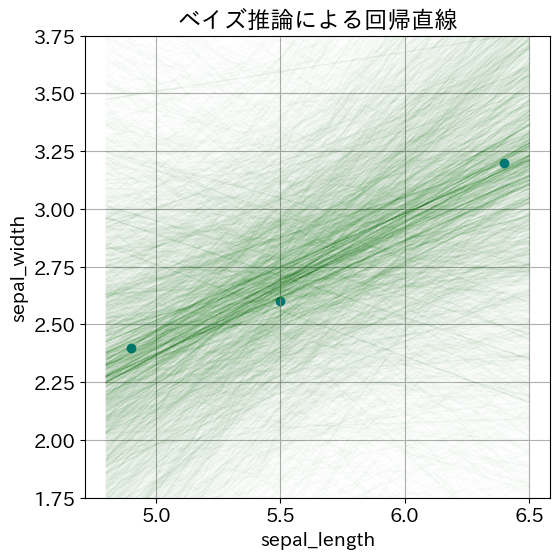

In [25]:
# xの２点をNumPy配列にする
x_values = np.array([X_less.min()-0.1, X_less.max()+0.1])

# サンプル値からalphaとbetaを取り出しshapeを加工する
alphas4 = idata4['posterior']['alpha'].values.reshape(-1, 1)
betas4 = idata4['posterior']['beta'].values.reshape(-1, 1)

# 2000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas4 + betas4

# 2000組の直線を散布図と同時表示
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c='g')
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title('ベイズ推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

#### バージョンの確認

In [26]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

pymc               : 5.11.0
numpy              : 1.26.4
matplotlib         : 3.8.3
pandas             : 2.2.1
arviz              : 0.17.1
japanize_matplotlib: 1.1.3
seaborn            : 0.12.2

